# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации
shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [138]:
import pandas as pd
import seaborn as sns
import pingouin as pg
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [139]:
reg_data = pd.read_csv('problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('problem1-auth_data.csv', sep = ';')

=========== Просто заголовки

In [140]:
reg_data.head(10)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
5,977206495,6
6,984222671,7
7,990407778,8
8,995943765,9
9,1000951674,10


In [141]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [142]:
auth_data.head(10)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
5,934372615,2
6,934662633,2
7,935002586,2
8,935141232,2
9,935682752,2


In [143]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

Так как первый столбик это время, попробую его распознать нормально и проверить как вывелось

In [144]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [145]:
auth_data.head(10)

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2
5,1999-08-11 11:56:55,2
6,1999-08-14 20:30:33,2
7,1999-08-18 18:56:26,2
8,1999-08-20 09:27:12,2
9,1999-08-26 15:52:32,2


In [146]:
reg_data.head(10)

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5
5,2000-12-19 06:14:55,6
6,2001-03-10 11:11:11,7
7,2001-05-21 01:16:18,8
8,2001-07-24 03:02:45,9
9,2001-09-20 02:07:54,10


===========  Другие обязательные проверки

In [147]:
# проверка на количество строк и столбцов
reg_data.shape

(1000000, 2)

In [148]:
# проверка на количество строк и столбцов
auth_data.shape

(9601013, 2)

In [149]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [150]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

Пропусков нет
Видно что регистраций 1.000.000 а входов 9.601.013

===========

Мне пришла идея проверитьт сколько у нас регистраций уникальных и сколько уникальных входов и все ли пользователи которые зарегистирировалась входили хоть раз

In [151]:
# количество уникальных регистраций 1 000 000
reg_data.uid.nunique()

1000000

In [152]:
# количество уникальных входов 1 000 000
auth_data.uid.nunique()

1000000

Теперь сравним все ли пользователи которые есть в регистрации заходили хотя бы один раз

In [153]:
array = reg_data.uid.unique() == auth_data.uid.unique()
if not all(array):  # проверяет, есть ли хотя бы один False
    print("Есть False")
else:
    print("Все значения True")

Все значения True


**Вывод: Значений пропущенных нет.
В таблице с регистарции только уникальные пользователи.
В таблице со входами содержит 1кк униканльных пользователей, которые входили несколько раз.
Все пользователи, которые зарегистрировались заходили хотя бы один раз**

# Задание 1.2
## Расчет Retention

К сожалению раз никто не объяснил задание и с ним кураторы не помогают, то я считаю, исходя из формулировки задания в данном случае, когда нужно "считать retention игроков (по дням от даты регистрации игрока)", обычно подразумевается точечный (дневной) retention.

Почему это скорее точечный retention?

-Формулировка "по дням"


Указано считать по дням с момента регистрации. Это значит, что нужно учитывать, сколько игроков возвращалось на конкретный день N (например, на 1-й, 2-й, 3-й день и т.д.).
Если бы требовался накопительный retention, формулировка скорее звучала бы как "удержание за определённый период".


Во втором варианте решения задачи я применю когортный анализ и тепловую карту


Первый вариант это общий ретеншн по всем пользователям по дням с момента регистрации

In [154]:
# соединяем 2 таблицы по uid
merged_data = pd.merge(auth_data, reg_data, on='uid', how='inner')
merged_data.head(10)

,auth_ts,uid,reg_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09
5,1999-08-11 11:56:55,2,1999-07-22 22:38:09
6,1999-08-14 20:30:33,2,1999-07-22 22:38:09
7,1999-08-18 18:56:26,2,1999-07-22 22:38:09
8,1999-08-20 09:27:12,2,1999-07-22 22:38:09
9,1999-08-26 15:52:32,2,1999-07-22 22:38:09


In [155]:
# считаем сколько дней прошло с момента регистрации
merged_data['days_since_registration'] = (merged_data['auth_ts'] - merged_data['reg_ts']).dt.days
merged_data.head(10)

,auth_ts,uid,reg_ts,days_since_registration
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43,0
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09,0
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09,2
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09,8
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09,13
5,1999-08-11 11:56:55,2,1999-07-22 22:38:09,19
6,1999-08-14 20:30:33,2,1999-07-22 22:38:09,22
7,1999-08-18 18:56:26,2,1999-07-22 22:38:09,26
8,1999-08-20 09:27:12,2,1999-07-22 22:38:09,28
9,1999-08-26 15:52:32,2,1999-07-22 22:38:09,34


In [156]:
# считаем сколько уникальных юзеров вошло в первый день, второй и тд

retention = (
    merged_data.groupby('days_since_registration')['uid'] # группируем дни регистрации по uid. Получается на 1 день множестно id. Считаем их
    .nunique()
    .reset_index()
    .rename(columns={'uid': 'unique_users'})
    )
retention.head(10)

,days_since_registration,unique_users
0,0,1000000
1,1,40202
2,2,42991
3,3,49152
4,4,56070
5,5,63713
6,6,72773
7,7,43626
8,8,49667
9,9,50373


In [157]:
# процент ретеншена от общего число пользователей
total_users = reg_data['uid'].nunique()
retention['retention_rate'] = retention['unique_users'] / total_users * 100  # процент удержания
retention.head(10)

,days_since_registration,unique_users,retention_rate
0,0,1000000,100.0000
1,1,40202,4.0202
2,2,42991,4.2991
3,3,49152,4.9152
4,4,56070,5.6070
5,5,63713,6.3713
6,6,72773,7.2773
7,7,43626,4.3626
8,8,49667,4.9667
9,9,50373,5.0373


In [158]:
# отрезаем всех кто вошел дальеш чем 60 дней
days_analys = 60
days_analys_retention = retention.query('days_since_registration <= @days_analys')

# ретеншн первого дня 100%, так что его можно отрезать
days_analys_retention_without_0 = retention.query('days_since_registration <= @days_analys and days_since_registration > 0')

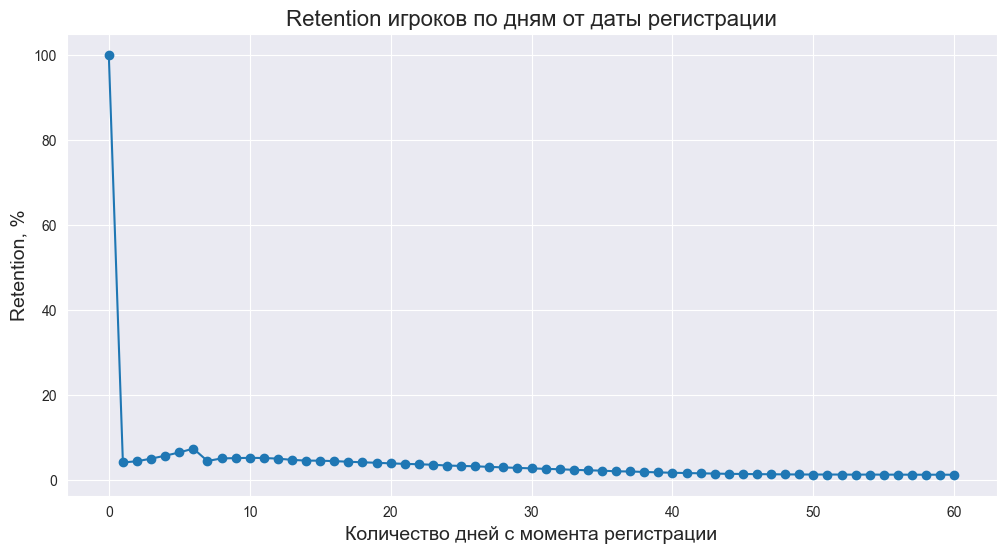

In [159]:
# график общего ретеншна начиная с дня 0 (по дням от даты регистрации игрока)

def plot_retention(retention_data):
    plt.figure(figsize=(12, 6))
    plt.plot(retention_data['days_since_registration'], retention_data['retention_rate'], marker='o')
    plt.title('Retention игроков по дням от даты регистрации', fontsize=16)
    plt.xlabel('Количество дней с момента регистрации', fontsize=14)
    plt.ylabel('Retention, %', fontsize=14)
    plt.grid(True)
    plt.show()

plot_retention(days_analys_retention)


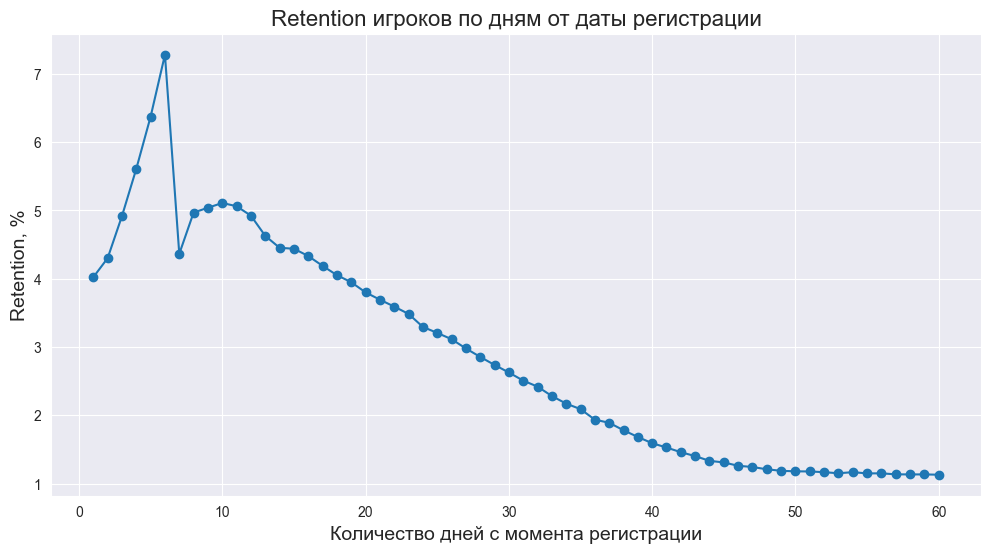

In [160]:
# общий ретеншн по дням без учета дня 0 (по дням от даты регистрации игрока)

def plot_retention(retention_data):
    plt.figure(figsize=(12, 6))
    plt.plot(retention_data['days_since_registration'], retention_data['retention_rate'], marker='o')
    plt.title('Retention игроков по дням от даты регистрации', fontsize=16)
    plt.xlabel('Количество дней с момента регистрации', fontsize=14)
    plt.ylabel('Retention, %', fontsize=14)
    plt.grid(True)
    plt.show()

plot_retention(days_analys_retention_without_0)


Второй вариант расчета задачи

если нужен когортный анализ

Тут мы берем выборку данных из аутентификайи и полные реги для оптимизации процесса

Затем задаем нужные даты для анализа

Проводим объединение выбранных данных

Считаем сколько дней прошло с момента первого входа

Группируем по дате регистрации и дню

Считаем сколько уникальных пользователей зашло в этот день

Делаем пивот таблицы, где в индексе будет день регистрации, а в колонке будет день. В значениях будет сколько уникальных пользователей в этот день

Далее рассчитываем ретеншн деля все значения на значение в столбике 0 (день 0)

In [161]:
reg_data.head(10)

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5
5,2000-12-19 06:14:55,6
6,2001-03-10 11:11:11,7
7,2001-05-21 01:16:18,8
8,2001-07-24 03:02:45,9
9,2001-09-20 02:07:54,10


In [162]:
# Преобразование данных в нужный формат
reg_data['registration'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.to_period('D')

# Выборка случайных данных из auth_date
# auth_sample = auth_data.sample(500000, random_state=1)

# Преобразование данных в нужный формат
# тут добавляется новый столбик с нормальными датами, который берется из auth_ts
auth_data['authorization'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.to_period('D')

# # Фильтрация данных по периоду
start = "2020-08-01"
end = "2020-08-07"
#
reg_filtered = reg_data.query('@start <= registration <= @end')

# не фильтруем датафрейм с аутентификациями иначе часть данных обрежется


# Объединение данных
# сохраняются все строки из первой таблицы (с которой производятся действия)
merged = reg_filtered.merge(auth_data, on='uid', how='left').dropna()
merged.head(10)

,reg_ts,uid,registration,auth_ts,authorization
0,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-01 00:00:04,2020-08-01
1,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-06 14:03:50,2020-08-06
2,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-11 12:52:26,2020-08-11
3,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-15 09:20:35,2020-08-15
4,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-18 03:27:04,2020-08-18
5,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-19 12:12:11,2020-08-19
6,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-25 11:28:59,2020-08-25
7,2020-08-01 00:01:01,1016864,2020-08-01,2020-08-01 00:01:01,2020-08-01
8,2020-08-01 00:01:59,1016865,2020-08-01,2020-08-01 00:01:59,2020-08-01
9,2020-08-01 00:02:56,1016866,2020-08-01,2020-08-01 00:02:56,2020-08-01


In [163]:
merged['days'] = (merged['authorization'] - merged['registration'])
merged['days'] = merged['days'].apply(lambda x: x.n)
merged.head(10)

,reg_ts,uid,registration,auth_ts,authorization,days
0,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-01 00:00:04,2020-08-01,0
1,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-06 14:03:50,2020-08-06,5
2,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-11 12:52:26,2020-08-11,10
3,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-15 09:20:35,2020-08-15,14
4,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-18 03:27:04,2020-08-18,17
5,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-19 12:12:11,2020-08-19,18
6,2020-08-01 00:00:04,1016863,2020-08-01,2020-08-25 11:28:59,2020-08-25,24
7,2020-08-01 00:01:01,1016864,2020-08-01,2020-08-01 00:01:01,2020-08-01,0
8,2020-08-01 00:01:59,1016865,2020-08-01,2020-08-01 00:01:59,2020-08-01,0
9,2020-08-01 00:02:56,1016866,2020-08-01,2020-08-01 00:02:56,2020-08-01,0


In [164]:
# Группируем данные по дате регистрации и количеству дней
# Тоесть группируется все дни захода всех пользователей по первой дате
grouped = merged.groupby(['registration', 'days'])

# Считаем количество уникальных пользователей в каждой группе
aggregated = grouped.agg(user_count=('uid', 'nunique'))

# Сбрасываем индексы, чтобы преобразовать их в столбцы
cohorts = aggregated.reset_index()

In [165]:
cohorts.head(10)

,registration,days,user_count
0,2020-08-01,0,1507
1,2020-08-01,1,29
2,2020-08-01,2,67
3,2020-08-01,3,65
4,2020-08-01,4,84
5,2020-08-01,5,89
6,2020-08-01,6,115
7,2020-08-01,7,96
8,2020-08-01,8,68
9,2020-08-01,9,96


In [166]:
# Создание сводной таблицы
pivot_table = cohorts.pivot(index='registration', columns='days', values='user_count')

pivot_table.head(10)

days,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
registration,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1507.0,29.0,67.0,65.0,84.0,89.0,115.0,96.0,68.0,96.0,...,27.0,21.0,27.0,11.0,14.0,24.0,24.0,18.0,19.0,13.0
2020-08-02,1509.0,39.0,61.0,66.0,78.0,98.0,100.0,91.0,68.0,80.0,...,22.0,16.0,20.0,19.0,20.0,16.0,25.0,21.0,6.0,NaN
2020-08-03,1512.0,26.0,65.0,61.0,84.0,93.0,114.0,80.0,75.0,74.0,...,30.0,27.0,23.0,22.0,23.0,17.0,15.0,14.0,NaN,NaN
2020-08-04,1514.0,31.0,54.0,71.0,79.0,80.0,98.0,78.0,67.0,71.0,...,25.0,26.0,20.0,20.0,22.0,15.0,12.0,NaN,NaN,NaN
2020-08-05,1517.0,39.0,53.0,61.0,87.0,77.0,118.0,93.0,64.0,72.0,...,19.0,24.0,10.0,16.0,16.0,8.0,NaN,NaN,NaN,NaN
2020-08-06,1519.0,26.0,77.0,87.0,85.0,87.0,114.0,92.0,76.0,88.0,...,18.0,17.0,17.0,15.0,17.0,NaN,NaN,NaN,NaN,NaN
2020-08-07,1522.0,33.0,47.0,80.0,81.0,91.0,109.0,94.0,78.0,76.0,...,20.0,22.0,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
# Расчёт retention
retention = pivot_table.divide(pivot_table[0], axis=0)
# тут мы обрезаем датафрейм, чтобы он не превратился в кашу
retention = retention.iloc[:, :8]
retention.head(10)

days,0,1,2,3,4,5,6,7
registration,,,,,,,,
2020-08-01,1.0,0.019244,0.044459,0.043132,0.055740,0.059058,0.076311,0.063703
2020-08-02,1.0,0.025845,0.040424,0.043738,0.051690,0.064944,0.066269,0.060305
2020-08-03,1.0,0.017196,0.042989,0.040344,0.055556,0.061508,0.075397,0.052910
2020-08-04,1.0,0.020476,0.035667,0.046896,0.052180,0.052840,0.064729,0.051519
2020-08-05,1.0,0.025709,0.034937,0.040211,0.057350,0.050758,0.077785,0.061305
2020-08-06,1.0,0.017117,0.050691,0.057275,0.055958,0.057275,0.075049,0.060566
2020-08-07,1.0,0.021682,0.030880,0.052562,0.053219,0.059790,0.071616,0.061761


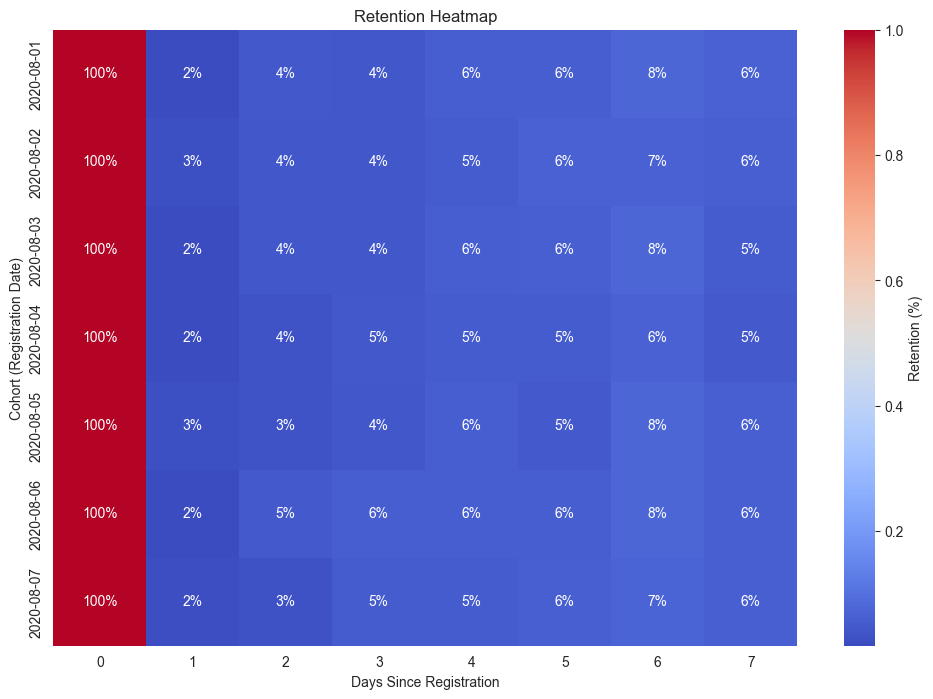

In [168]:
# Построение тепловой карты

plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="coolwarm", cbar_kws={'label': 'Retention (%)'})
plt.title('Retention Heatmap')
plt.xlabel('Days Since Registration')
plt.ylabel('Cohort (Registration Date)')
plt.show()

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Конверсия в платящего пользователя

Контроль: 1928 / 202 103 ≈ 0,95%

Тест: 1805 / 202 667 ≈ 0,89%

**В тесте конверсия чуть ниже, а ARPU выше**



Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?



=========

В каком смысле лучшим?
Если мы зарабатываем деньги то здесь рост ARPPU и общей выручки

Но если наша основная цель — увеличивать конверсию в платёж и расширять платящую аудиторию, то для нас лучшим будет контрольная группа

Для начала просто проверим данные

In [169]:
ab_test = pd.read_csv('project_1_ex_2.csv', sep=';')
ab_test.head(10)


,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
7,8,0,b
8,9,0,b
9,10,0,a


In [170]:
ab_test.head(10)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
7,8,0,b
8,9,0,b
9,10,0,a


In [171]:
# смотрим сколько строк и столбцов
ab_test.shape

(404770, 3)

In [172]:
# все ли id пользователей уникальны в таблице
ab_test.user_id.nunique() == ab_test.shape[0]

True

In [173]:
# тип полей в датафрейме
ab_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [174]:
# есть ли пропуски
ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [175]:
# првоерка дубликатов
duplicates = ab_test.duplicated().sum()
duplicates

np.int64(0)

In [176]:
ab_test.testgroup.value_counts()

testgroup
b    202667
a    202103
Name: count, dtype: int64

**Выводы- пользователи уникальные**

пропущенных значений нет

In [177]:
# общая выручка по группам
(ab_test.groupby(['testgroup'], as_index=False).agg({'revenue': 'sum'})).rename(columns={"revenue": "total_revenue"})

,testgroup,total_revenue
0,a,5136189
1,b,5421603


Мы видим, что в группе б общая выручка больше чем в а

# Оценим данные визуально

<Axes: xlabel='revenue', ylabel='testgroup'>

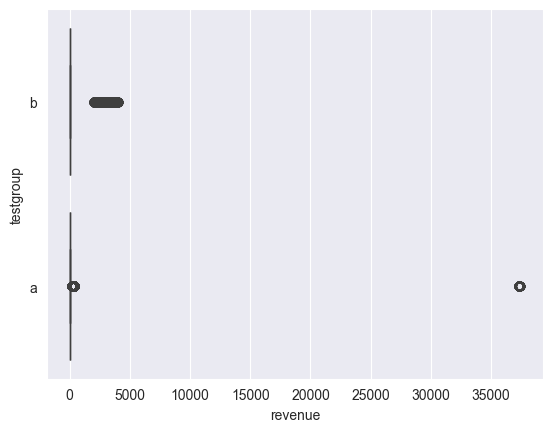

In [178]:
sns.boxplot(x='revenue', y='testgroup', data= ab_test)

In [179]:
# Распределеним по группам

control = ab_test.query('testgroup == "a"') # а - контроль все
test = ab_test.query('testgroup == "b"')    # б - тест все



control_pays = ab_test.query('testgroup == "a" and revenue != 0') # контроль платящие
test_pays = ab_test.query('testgroup == "b" and revenue != 0')    # тест платящие



control_not_pays = ab_test.query('testgroup == "a" and revenue == 0') # контроль не платящие
test_not_pays = ab_test.query('testgroup == "b" and revenue == 0')    # тест не платищие


Посмотрим на данные, как они распределены

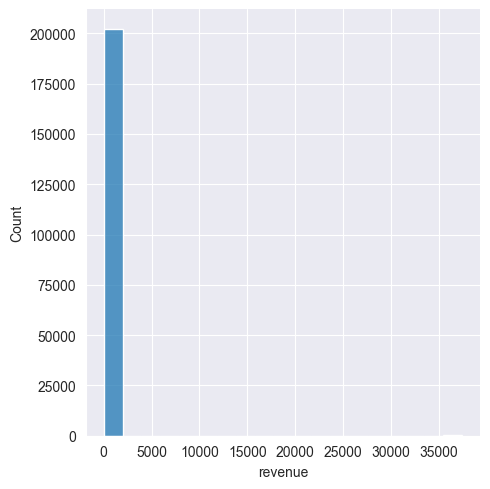

In [180]:
sns.displot(x = 'revenue', data = control )

In [181]:
control.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


тут есть значения больше чем 0, но их очень мало

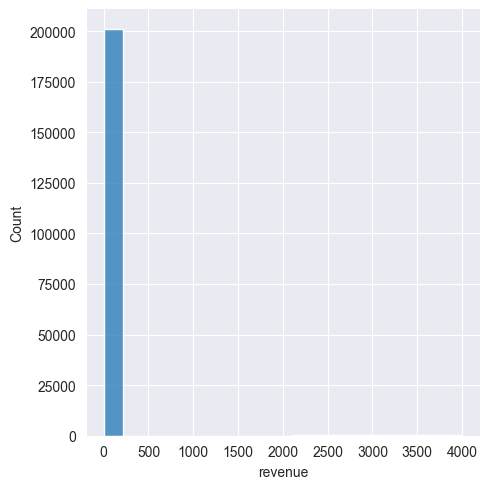

In [182]:
sns.displot(x = 'revenue', data = test )

In [183]:
test.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


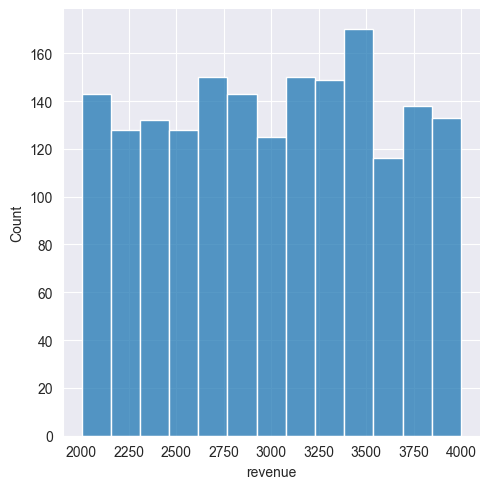

In [184]:
sns.displot(x = 'revenue', data = test_pays)

In [185]:
test_pays.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


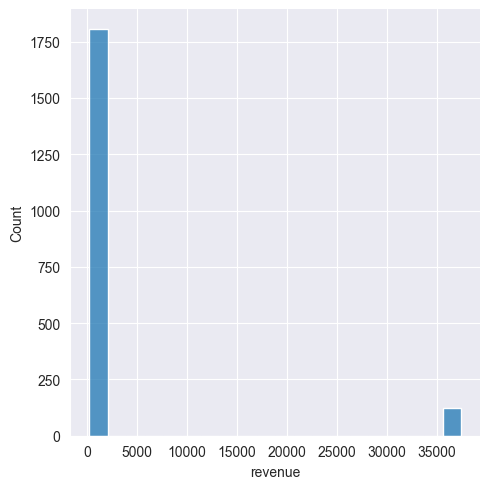

In [186]:
sns.displot(x = 'revenue', data = control_pays, bins=20)

In [187]:
control_pays.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [188]:
# процент платящих в контрольной группе
control_procent_pays = control_pays.shape[0] / control.shape[0] * 100
control_procent_pays

0.9539690157988748

In [189]:
# процент платящих в тестовой группе
test_procent_pays = test_pays.shape[0] / test.shape[0] * 100
test_procent_pays

0.8906235351586593

In [190]:
# Вычисление квартилей и межквартильного размаха для контрольной группы
q1_control = control['revenue'].quantile(0.25)
q3_control = control['revenue'].quantile(0.75)
iqr_control = q3_control - q1_control

# Границы выбросов для контрольной группы
lower_bound_control = q1_control - 1.5 * iqr_control
upper_bound_control = q3_control + 1.5 * iqr_control

# Вывод границ
print(f"Контрольная группа: Нижняя граница = {lower_bound_control}, Верхняя граница = {upper_bound_control}")

# Аналогично для тестовой группы
q1_test = test['revenue'].quantile(0.25)
q3_test = test['revenue'].quantile(0.75)
iqr_test = q3_test - q1_test

# Границы выбросов для тестовой группы
lower_bound_test = q1_test - 1.5 * iqr_test
upper_bound_test = q3_test + 1.5 * iqr_test

# Вывод границ
print(f"Тестовая группа: Нижняя граница = {lower_bound_test}, Верхняя граница = {upper_bound_test}")


# Отфильтруем выбросы
control_filtered = control[(control['revenue'] >= lower_bound_control) & (control['revenue'] <= upper_bound_control)]
test_filtered = test[(test['revenue'] >= lower_bound_test) & (test['revenue'] <= upper_bound_test)]

# Выводим информацию о количестве удалённых выбросов
print(f"Удалено выбросов в контрольной группе: {control.shape[0] - control_filtered.shape[0]}")
print(f"Удалено выбросов в тестовой группе: {test.shape[0] - test_filtered.shape[0]}")



# Вычисление процента выбросов в контрольной группе
control_outliers_count = control.shape[0] - control_filtered.shape[0]
control_outliers_percent = (control_outliers_count / control.shape[0]) * 100

# Вычисление процента выбросов в тестовой группе
test_outliers_count = test.shape[0] - test_filtered.shape[0]
test_outliers_percent = (test_outliers_count / test.shape[0]) * 100

# Вывод информации
print(f"Удалено выбросов в контрольной группе: {control_outliers_count} ({control_outliers_percent:.2f}%)")
print(f"Удалено выбросов в тестовой группе: {test_outliers_count} ({test_outliers_percent:.2f}%)")

Контрольная группа: Нижняя граница = 0.0, Верхняя граница = 0.0
Тестовая группа: Нижняя граница = 0.0, Верхняя граница = 0.0
Удалено выбросов в контрольной группе: 1928
Удалено выбросов в тестовой группе: 1805
Удалено выбросов в контрольной группе: 1928 (0.95%)
Удалено выбросов в тестовой группе: 1805 (0.89%)


По этим данным мы также можем сделать вывод, что в тестовой группе выручка составляет 5 421 603 рубля. В контрольной выручка составляет 5 136 189 рублей. Максимальный чек в контрольный группе составил 37 433 рубля, а в тестовой 4 000 рублей.
На данном этапе мы не можем сделать однозначного предположения какой набор является лучшим

В данном случае я рекомендую не убирать выбросы, так как очень низкий процент платящих

При использовании межкавртильного размаха мы убираем слишком большое количество информации, которое вообще не позволяет провести анализ


Далее проверим следующие метрики

- ARPU
- ARPPU
- CR


Проверим конверсию из задачи

Конверсия это количество платящих пользователей / общее количество пользователей по двум группам
ARPU

In [191]:
# проверка конверсии контрольной группы
control_conversion = control_pays.shape[0] / control.shape[0] * 100
control_conversion


0.9539690157988748

In [192]:
# проверка конверсии тестовой группы
test_conversion = test_pays.shape[0] / test.shape[0] * 100
test_conversion

0.8906235351586593

Проверка ARPU

Общий доход / общее количество пользователей

In [193]:
# рассчитываем ARPU в контроле
control_summ = control['revenue'].sum()
control_user_count = control['user_id'].nunique()
control_arpu = control_summ / control_user_count
control_arpu

np.float64(25.413719736965806)

In [194]:
# рассчитываем ARPU в тесте
test_summ = test['revenue'].sum()
test_user_count = test['user_id'].nunique()
test_arpu = test_summ / test_user_count
test_arpu

np.float64(26.75128659327863)

In [195]:
# разница в процентах
percenttage_difference = (test_arpu - control_arpu) / test_arpu * 100
percenttage_difference

np.float64(5.00000944496214)

- arpu
- контроль 25.41
- тест 26.75

### Расчет ARPPU

In [196]:
control_arppu = control.query('revenue > 0')['revenue'].mean()
control_arppu

np.float64(2663.9984439834025)

In [197]:
test_arppu = test.query('revenue > 0')['revenue'].mean()
test_arppu

np.float64(3003.6581717451522)

- arppu
- контроль 2663.99
- тест 3003.65

### Расчет CR

In [198]:
ab_test['is_paying'] = ab_test['revenue'].apply(lambda x: 1 if x > 0 else 0)
ab_test.head(10)

,user_id,revenue,testgroup,is_paying
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
5,6,0,b,0
6,7,0,b,0
7,8,0,b,0
8,9,0,b,0
9,10,0,a,0


In [199]:
control_cr = ab_test[ab_test['testgroup'] == 'a']['is_paying'].mean() * 100
control_cr

np.float64(0.9539690157988748)

In [200]:
test_cr = ab_test[ab_test['testgroup'] == 'b']['is_paying'].mean() * 100
test_cr

np.float64(0.8906235351586593)

- В контрольной группе CR 0.95
- В тестовой группе CR 0.89

---
- arpu
- контроль 25.41
- тест 26.75
---
- arppu
- контроль 2663.99
- тест 3003.65
---
- CR
- контроль CR 0.95
- тест CR 0.89

В тестовой группе arpu и arppu выше чем в контрольной. Зато в контрольной группе выше CR

## Тестирование гипотез

__ARPU__

- H 0 : Нулевая гипотеза утверждает, что средние значения в двух генеральных совокупностях равны (нет значимых различий).
- H 1 : Альтернативная гипотеза утверждает, что средние значения в двух генеральных совокупностях отличаются.

In [201]:
# тест на гомоскедастичность
pg.homoscedasticity(data=ab_test, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


p-value > 0.05, дисперсии гомогенны

Применяем t-test

In [202]:
stats.ttest_ind(control.revenue, test.revenue)

TtestResult(statistic=np.float64(-0.6242026493616787), pvalue=np.float64(0.532494858971837), df=np.float64(404768.0))

p-value > 0.05

H0 отклонить не можем- статистически значимых различий ARPU между группами нет

#### ARPU

- H 0 : Нулевая гипотеза утверждает, что средние значения в двух генеральных совокупностях равны (нет значимых различий).
- H 1 : Альтернативная гипотеза утверждает, что средние значения в двух генеральных совокупностях отличаются.

In [203]:
pg.homoscedasticity(data=ab_test.query("revenue > 0"), dv="revenue", group="testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


Диспресии не гомогенны, по этому используем t-критерий Уэлча

In [204]:
stats.ttest_ind(control.query("revenue > 0").revenue, test.query("revenue > 0").revenue,
                equal_var=False)

TtestResult(statistic=np.float64(-1.644630266430084), pvalue=np.float64(0.10020780398916018), df=np.float64(1943.4815217434643))

p-value > 0.05

H0 отклонить не можем- статистически значимых различий ARPPU между группами нет

### CR

- H 0 : Нулевая гипотеза утверждает, что средние значения в двух генеральных совокупностях равны (нет значимых различий).
- H 1 : Альтернативная гипотеза утверждает, что средние значения в двух генеральных совокупностях отличаются.

Так как значения биноминальные, то используем хи-квадрат

In [205]:
stats.chi2_contingency(pd.crosstab(ab_test.testgroup, ab_test.is_paying))

Chi2ContingencyResult(statistic=np.float64(4.374729521260405), pvalue=np.float64(0.03647561892312609), dof=1, expected_freq=array([[200239.10075104,   1863.89924896],
       [200797.89924896,   1869.10075104]]))

p-value < 0.05
Присутствуют статистически значимые различия между группами

### Вывод по заданию 2

#### Общие результаты метрик
- **ARPU (Average Revenue Per User)**:
  - Контрольная группа: **25.41 руб.**
  - Тестовая группа: **26.75 руб.**
  - **Разница**: +5% в пользу тестовой группы.
- **ARPPU (Average Revenue Per Paying User)**:
  - Контрольная группа: **2663.99 руб.**
  - Тестовая группа: **3003.65 руб.**
  - **Разница**: +12.7% в пользу тестовой группы.
- **CR (Conversion Rate)**:
  - Контрольная группа: **0.95%.**
  - Тестовая группа: **0.89%.**
  - **Разница**: -0.06% в тестовой группе (значительное снижение).

#### Гипотезы и тестирование
- **ARPU**:
  - Нулевая гипотеза (H₀): Средние значения ARPU в группах равны.
  - Результат: p-value > 0.05. Статистически значимых различий между группами нет.
- **ARPPU**:
  - Нулевая гипотеза (H₀): Средние значения ARPPU в группах равны.
  - Результат: p-value > 0.05. Статистически значимых различий между группами нет.
- **CR**:
  - Нулевая гипотеза (H₀): Конверсия в платящих пользователей одинакова в обеих группах.
  - Результат: p-value < 0.05. Контрольная группа показала статистически значимо лучший результат.

#### Общая выручка
- **Контрольная группа**: 5,136,189 руб.
- **Тестовая группа**: 5,421,603 руб.
- Тестовая группа показала более высокую выручку, но значимая разница в ARPU отсутствует.

#### Рекомендации
- **Тестовый набор предложений внедрять не рекомендуется**, так как:
  - Отсутствуют доказательства статистически значимого роста ARPU или ARPPU.
  - Конверсия (CR) в тестовой группе значительно ниже.
- **Контрольная группа предпочтительна**, особенно если цель заключается в увеличении платящей аудитории.


#### Итог
Несмотря на локальные успехи тестовой группы по ARPU и ARPPU, снижение CR и отсутствие статистически значимых различий делают **контрольный набор предложений** более предпочтительным.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

---

## Метрики для оценки эффективности игровых событий

## Базовые метрики
1. **Уникальные игроки события (Unique Players per Event)**
   Количество уникальных игроков, участвовавших в событии.
   *Применение*: Анализ охвата аудитории и сравнение текущего события с прошлыми.

2. **Ежедневно активные пользователи (DAU - Daily Active Users)**
   Число пользователей, которые заходят в игру в день.
   *Применение*: Отражает вовлеченность аудитории, помогает отслеживать влияние событий на ежедневную активность.

3. **Ежемесячно активные пользователи (MAU - Monthly Active Users)**
   Число пользователей, которые заходят в игру в течение месяца.
   *Применение*: Оценка долгосрочной активности аудитории.

4. **Липкость (Stickiness)**
   Отношение DAU к MAU, показывающее, как часто пользователи возвращаются в игру.
   *Применение*: Сравнение активности в разные периоды (например, до и после события).

5. **Среднее время в событии (Average Time per Event)**
   Среднее время, которое игрок проводит в рамках события.
   *Применение*: Анализ вовлеченности по дням или за весь период.

---

## Метрики монетизации
6. **Средний доход на активного пользователя (ARPDAU - Average Revenue Per Daily Active User)**
   Доход, приходящийся на одного активного пользователя.
   *Формула*: `Дневной доход / DAU`.

7. **Средний доход на платящего пользователя (ARPPU - Average Revenue Per Paying User)**
   Доход от одного пользователя, совершающего внутриигровые покупки.
   *Применение*: Оценка эффективности монетизации.

8. **Затраты в событии (Spent Coins/Characters)**
   Количество игровых ресурсов (монет, персонажей), потраченных в событии.
   *Применение*: Измерение влияния события на экономику игры.

9. **Доход от события (Event Revenue)**
   Общая сумма дохода, полученного в рамках события.
   *Применение*: Анализ эффективности событийных механик.

---

## Метрики удержания
10. **Retention Rate**
    Процент пользователей, вернувшихся в игру за определённый период.
    *Формула*: `Число вернувшихся игроков / Число пользователей на начало периода`.

11. **Отток пользователей (Churn Rate)**
    Процент игроков, покинувших игру за расчётный период.
    *Применение*: Выявление причин ухода (например, баги или сложные механики).

12. **Удержание игроков на уровнях (Level Retention)**
    Процент пользователей, прошедших каждый уровень события.
    *Применение*: Анализ точек оттока и интереса к событию.

---

## Дополнительные метрики
13. **Количество игровых сессий (Session Count)**
    Число игровых сессий за день или за весь период события.
    *Применение*: Измерение вовлечённости аудитории.

14. **Продолжительность игровой сессии (Session Duration)**
    Среднее время одной игровой сессии.
    *Применение*: Оценка глубины вовлечённости.

15. **Полученные награды (Earned Coins/Characters)**
    Количество игровых ресурсов, заработанных за период события.
    *Применение*: Оценка баланса сложности и привлекательности контента.

16. **Частота обращений в службу поддержки (Support Requests)**
    Количество запросов в поддержку за период события.
    *Применение*: Выявление проблем, требующих улучшения.

---

## Неочевидные метрики
17. **Упоминания в соцсетях и на форумах (Event Mentions)**
    Количество упоминаний события в социальных сетях и на тематических платформах.
    *Применение*: Косвенная оценка популярности события.

18. **Вторичный рынок (Secondary Market)**
    Стоимость уникальных игровых персонажей или ресурсов, появившихся в событии, на вторичном рынке.
    *Применение*: Анализ ценности игровых активов для аудитории.

---

## Итоговые метрики
19. **LTV (Lifetime Value)**
    Долгосрочная ценность пользователя.
    *Формула*: `Общий доход, принесённый игроком за весь период его активности`.

20. **Установки приложения (App Installations)**
    Количество новых установок игры за период события.
    *Применение*: Оценка привлечения новой аудитории.

# Задание 3.1
Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Дополнительные Guardrail-метрики

## Метрики игровых неудач
1. **Количество неудачных попыток выполнения уровня на игрока (Failed Attempts per Player)**
   Число проваленных попыток выполнения уровня для каждого игрока.
   *Применение*: Анализ сложности уровней и возможных точек оттока.

2. **Откаты по уровням (Level Rollbacks)**
   Количество уровней, на которые игрок откатился после неудачи.
   *Применение*: Выявление фрустрации игроков и сложностей геймплея.

3. **Заброшенные события после откатов (Drop Rate After Rollbacks)**
   Процент игроков, которые прекратили прохождение события после откатов.
   *Применение*: Оценка влияния неудач на мотивацию игроков.

---

## Метрики вовлеченности после неудач
4. **Частота возвращений после провалов уровня (Return Rate After Failure)**
   Доля игроков, вернувшихся к событию после неудачи.
   *Применение*: Анализ того, как события мотивируют или демотивируют игроков после сложностей.

5. **Число попыток после откатов (Number of Attempts After Rollback)**
   Количество попыток, предпринятых игроком после отката на предыдущие уровни.
   *Применение*: Измерение настойчивости игроков и оценки сложности событий.